In [ ]:
#| default_exp clip_plot

In [ ]:
#| hide

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports and setup

### Unconditional imports

In [ ]:
#|export

from __future__ import division
import warnings

warnings.filterwarnings("ignore")

In [ ]:
#| export

# print separately that we're loading dependencies, as this can take a while
# and we want to give immediate feedback the program is starting
from clip_plot.utils import timestamp
print(timestamp(), "Beginning to load dependencies")


2025-10-03 16:53:00.202613: Beginning to load dependencies


In [ ]:
#|export

from fastcore.all import call_parse, in_ipython, Param, store_true
from pathlib import Path
from tqdm.auto import tqdm

from clip_plot.from_tables import glob_to_tables, table_to_meta
from clip_plot.web_config import get_clip_plot_root, copy_web_assets
from clip_plot.embeddings import get_timm_embeds
from clip_plot.metadata import get_manifest, write_metadata
from clip_plot.images import create_atlases_and_thumbs, ImageFactory

In [ ]:
#| export

from shutil import rmtree
from pathlib import Path
from typing import Optional, List, Union, Tuple
import uuid
import sys
import os
import pandas as pd

### Image processing imports

Note that I have removed the "copy-web-only" conditional import path for now

`nbdev` does not like cells to have cells to have code and imports in the same cell:

https://nbdev.fast.ai/getting_started.html#q-what-is-the-warning-found-a-cell-containing-mix-of-imports-and-computations.-please-use-separate-cells

I think this may mean we don't get to do conditional imports. If we find a code path that really should have conditional imports, we can see if there is a workaround. For now, I don't feel "copy web only" is a very important functionality to keep.

In [ ]:
#| export


import numpy as np
import random
import copy
import json

### Optional install imports

In [ ]:
#| export

DEFAULTS = {
    "images": None,
    "tables": None,
    "meta_dir": None,
    "out_dir": "output",
    "max_images": None,
    "use_cache": True,
    "encoding": "utf8",
    "cluster_preproc_dims": -1,
    "min_cluster_size": 20,
    "max_clusters": 10,
    "atlas_size": 2048,
    "cell_size": 32,
    "lod_cell_height": 128, # Why is not in parser?
    "embed_model": "tf_inception_v3",
    "n_neighbors": [15],
    "min_dist": [0.01],
    "umap_on_full_dims": False,
    "n_components": 2,
    "metric": "correlation",
    "pointgrid_fill": 0.05,
    "gzip": False,
    "min_size": 100,
    "min_score": 0.3,
    "min_vertices": 18,
    "plot_id": str(uuid.uuid1()),
    "seed": 24,
    "n_clusters": 12,
    "geojson": None,
}

# handle truncated images in PIL (managed by Pillow)
PILLoadTruncated  = True

"""
NB: Keras Image class objects return image.size as w,h
    Numpy array representations of images return image.shape as h,w,c
"""

'\nNB: Keras Image class objects return image.size as w,h\n    Numpy array representations of images return image.shape as h,w,c\n'


## Entry

`project_images` will kick off all the main functions for the module

In [ ]:
#| export

def _project_images(imageEngine, embeds: Optional[np.ndarray]=None, **kwargs):
    """
    Main method for embedding user images, projecting to 2D, and creating visualization
    It would be nice to list out the image processing steps before getting started
    """
    kwargs = umap_args_to_list(**kwargs)
    print(timestamp(), "Starting image processing pipeline.")

    copy_web_assets(out_dir=kwargs['out_dir'],
                    tagline=kwargs['tagline'], logo=kwargs["logo"])
    if kwargs["copy_web_only"]:
        print(timestamp(), "Done!")
        sys.exit()
    
    np.random.seed(kwargs["seed"])
    kwargs["out_dir"] = os.path.join(kwargs["out_dir"], "data")
    write_metadata(imageEngine, kwargs["gzip"], kwargs["encoding"])
    
    kwargs["atlas_dir"], atlas_data = create_atlases_and_thumbs(imageEngine, kwargs["plot_id"], kwargs["use_cache"])
    
    if embeds is None:
        kwargs["vecs"], _ = get_timm_embeds(imageEngine, model_name=kwargs["embed_model"],
                                            data_dir=Path(kwargs["out_dir"]), **kwargs)
    else:
        kwargs["vecs"] = embeds

    get_manifest(imageEngine, atlas_data, **kwargs)
    # write_images(imageEngine)
    print(timestamp(), "Done!")

In [ ]:
#| export

def umap_args_to_list(**kwargs):
    """Convert n_neighbors and min_dist arguments into lists

    Args:
        n_neighbors (int, list[int], default = [15])
        min_dist (int, list[int], default = [0.01])
    """
    for i in ["n_neighbors", "min_dist"]:
        if not isinstance(kwargs[i], list):
            kwargs[i] = [kwargs[i]]
    return kwargs

## Carlo's Test Functions

> Need to remove later

In [ ]:
#| export

copy_root_dir = get_clip_plot_root()

def test_iiif(config):
    test_images = copy_root_dir/"tests/IIIF_examples/iif_example.txt"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"

    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()
    config["plot_id"] = "test_diff"

    return config


def test_butterfly_duplicate(config):
    test_images = copy_root_dir/"tests/smithsonian_butterflies_10/jpgs_duplicates/**/*.jpg"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"
    meta_dir = copy_root_dir/"tests/smithsonian_butterflies_10/meta_data/good_meta.csv"
    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()
    config["meta_dir"] = meta_dir.as_posix()
    config["plot_id"] = "test_diff"

    return config

def test_butterfly_missing_meta(config):
    test_images = copy_root_dir/"tests/smithsonian_butterflies_10/jpgs/*.jpg"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"
    meta_dir = copy_root_dir/"tests/smithsonian_butterflies_10/meta_data/meta_missing_entry.csv"
    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()
    config["meta_dir"] = meta_dir.as_posix()
    config["plot_id"] = "test_diff"

    return config

def test_no_meta_dir(config):
    test_images = copy_root_dir/"tests/smithsonian_butterflies_10/jpgs/*.jpg"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"
    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()
    config["plot_id"] = "test_diff"

    return config


# Project images

Command-line function thanks to @call_parse decorator

In [ ]:
#| export

@call_parse
def project_images(images:Param(type=str,
                        help="path or glob of images to process"
                        )=DEFAULTS["images"],
                tables:Param(type=str,
                        help="path or glob of tables with image_path and embed_path columns (and optionally metadata)"
                        )=None,
                metadata:Param(type=str,
                        help="path to a csv or glob of JSON files with image metadata (see readme for format)"
                        )=DEFAULTS["meta_dir"],
                tagline:Param(type=str,
                        help="tagline for image web page"
                        )="Images arranged by visual similarity",
                logo:Param(type=str,
                        help="path to a small, squarish logo -- SVG is best"
                        )=None,
                max_images:Param(type=int,
                        help="maximum number of images to process"
                        )=DEFAULTS["max_images"],
                use_cache:Param(type=store_true,
                        help="given inputs identical to prior inputs, load outputs from cache"
                        )=DEFAULTS["use_cache"],
                encoding:Param(type=str,
                        help="the encoding of input metadata"
                        )=DEFAULTS["encoding"],
                cluster_preproc_dims:Param(type=int,
                        help="number of dims to reduce to prior to clustering. -1 means don't reduce",
                        required=False
                        )=DEFAULTS["cluster_preproc_dims"],
                min_cluster_size:Param(type=int,
                        help="the minimum number of images in a cluster",
                        required=False
                        )=DEFAULTS["min_cluster_size"],
                max_clusters:Param(type=int,
                        help="the maximum number of clusters to return",
                        required=False
                        )=DEFAULTS["max_clusters"],
                out_dir:Param(type=str,
                        help="the directory to which outputs will be saved",
                        required=False
                        )=DEFAULTS["out_dir"],
                cell_size:Param(type=int,
                        help="the size of atlas cells in px",
                        required=False
                        )=DEFAULTS["cell_size"],
                embed_model:Param(type=str,
                        help="pre-trained model from timm library to use to create embedding",
                        required=False
                        )=DEFAULTS["embed_model"],
                n_neighbors:Param(type=int,
                        nargs="+",
                        help="the n_neighbors arguments for UMAP"
                        )=DEFAULTS["n_neighbors"],
                min_dist:Param(type=float,
                        nargs="+",
                        help="the min_dist arguments for UMAP"
                        )=DEFAULTS["min_dist"],
                umap_on_full_dims:Param(type=store_true,
                        help="skip PCA (faster dimensionality reduction) prior to UMAP"
                        )=DEFAULTS["umap_on_full_dims"],
                n_components:Param(type=int,
                        help="the n_components argument for UMAP"
                        )=DEFAULTS["n_components"],
                metric:Param(type=str,
                        help="the metric argument for umap"
                        )=DEFAULTS["metric"],
                pointgrid_fill:Param(type=float,
                        help="float 0:1 that determines sparsity of jittered distributions (lower means more sparse)"
                        )=DEFAULTS["pointgrid_fill"],
                copy_web_only:Param(type=store_true,
                        help="update ./output/assets without reprocessing data"
                        )=False,
                min_size:Param(type=float,
                        help="min size of cropped images"
                        )=DEFAULTS["min_size"],
                gzip:Param(type=store_true,
                        help="save outputs with gzip compression"
                        )=False,
                shuffle:Param(type=store_true,
                        help="shuffle the input images before data processing begins"
                        )=False,
                plot_id:Param(type=str,
                        help="unique id for a plot; useful for resuming processing on a started plot"
                        )=DEFAULTS["plot_id"],
                seed:Param(type=int, help="seed for random processes"
                           )=DEFAULTS["seed"],
                n_clusters:Param(type=int,
                        help="number of clusters if using kmeans"
                        )=DEFAULTS["n_clusters"],
                geojson:Param(type=str,
                        help="path to a GeoJSON file with shapes to be rendered on a map"
                        )=DEFAULTS["geojson"]
                ):
                "Convert a folder of images into a clip-plot visualization"

                # grab local variables as configuration dict
                config = dict(locals())


                # some parameters exist in DEFAULTS but not in the function signature
                default_only_keys = set(set(DEFAULTS.keys() - config.keys()))
                default_only = {k:DEFAULTS[k] for k in default_only_keys}
                config.update(default_only)

                options = {
                        'shuffle': config['shuffle'], 
                        'seed': config['seed'], 
                        'max_images': config['max_images'], 
                        'atlas_size': config['atlas_size'], 
                        'cell_size': config['cell_size'], 
                        'lod_cell_height': config['lod_cell_height'], 
                        'validate': True, 
                }

                if not tables:
                        embeds = None
                        table = None
                else:
                        if images is not None: raise ValueError("Provide either tables or images parameter, not both.")
                        print(timestamp(), "Loading tables")
                        table = glob_to_tables(tables)
                        config["images"] = list(table.image_path.values)
                        images = config["images"]
                        print(timestamp(), "Loading embeddings from disk")
                        embeds = np.array([np.load(e) for e in tqdm(table.embed_path)])

                data_dir = os.path.join(config["out_dir"], "data")
                imageEngine = ImageFactory(config['images'], data_dir, config['meta_dir'], options)
                
                # grab metadata from table if provided
                if table is not None:
                        imageEngine.meta_headers, imageEngine.metadata = table_to_meta(table) 

                _project_images(imageEngine, embeds, **config)

### Embed images without building visualization

Outputs a table linking the embedding files to the images

Test with bash command:
```
clipplot_embed_images --images "tests/smithsonian_butterflies_10/jpgs/*.jpg" --out_dir "tests/smithsonian_butterflies_10/DELETEME_embed_only" --metadata "tests/smithsonian_butterflies_10/meta_data/good_meta.csv"
```

In [ ]:
#| export

@call_parse
def embed_images(images:Param(type=str,
                        help="path or glob of images to process"
                        )=DEFAULTS["images"],
                embed_model:Param(type=str,
                        help="pre-trained model from timm library to use to create embedding",
                        required=False
                        )=DEFAULTS["embed_model"],
                out_dir:Param(type=str,
                        help="the directory to which outputs will be saved",
                        required=False
                        )=DEFAULTS["out_dir"],
                metadata:Param(type=str,
                        help="path to a csv or glob of JSON files with image metadata (see readme for format)"
                        )=DEFAULTS["meta_dir"],
                table_id:Param(type=str,
                        help="identifier for table that links embeddings to images and (optionally) metadata",
                        required=False
                        )=str(uuid.uuid1()),
                table_format:Param(type=str,
                        choices=["parquet", "csv"],
                        help="format for table linking embeddings, images, and metadata",
                        required=False
                        )="parquet",
                seed:Param(type=int, help="seed for random processes"
                           )=DEFAULTS["seed"],
                ):
                "Embed a folder of images and save embeddings as .npy file to disk"

                kwargs = {"seed": seed, "use_cache": False}

                # using Path.cwd() to handle ../ names -- not sure if this is superstitious
                data_dir = Path.cwd() / Path(out_dir).resolve() / "data"

                imageEngine = ImageFactory(img_path=images, out_dir=data_dir, meta_dir=metadata)
                _, embed_paths = get_timm_embeds(imageEngine, model_name=embed_model,
                                                data_dir=data_dir, **kwargs)
                
                df = pd.DataFrame({"image_path": imageEngine.image_paths,
                                   "image_filename": imageEngine.filenames,
                                   "embed_path": embed_paths})

                if len(imageEngine.metadata) > 0:
                        df_meta = pd.DataFrame(imageEngine.metadata)
                        df_meta = df_meta.rename(columns={"filename": "image_filename"})
                        # drop "image_path" column if df_meta has it
                        if "image_path" in df_meta.columns:
                                df_meta = df_meta.drop(columns=["image_path"])

                        df = df.merge(df_meta.drop_duplicates(["image_filename"]), on="image_filename")

                ## standardize sort order of table
                # put standard columns first if they exist in df
                standard_cols = pd.Index(["image_path", "image_filename", "embed_path", "category", "tags", "x", "y"])
                cols_sorted = standard_cols.intersection(df.columns)
                # append non-standard columns, sorted alphabetically
                cols_sorted = cols_sorted.append(df.columns.difference(standard_cols).sort_values())
                df = df[cols_sorted]

                if table_format == "csv":
                        df.to_csv(data_dir / f"EmbedImages__{table_id}.csv", index=False)
                else: df.to_parquet(data_dir / f"EmbedImages__{table_id}.parquet", index=False)

In [ ]:
#| hide

def test_butterfly():
    test_images = copy_root_dir/"tests/smithsonian_butterflies_10/jpgs/*.jpg"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"
    meta = copy_root_dir/"tests/smithsonian_butterflies_10/meta_data/good_meta.csv"
    if Path(test_out_dir).exists():
        rmtree(test_out_dir)
    
    project_images(images=test_images.as_posix(),
                   out_dir=test_out_dir.as_posix(),
                   metadata=meta.as_posix(),
                   plot_id="test_diff",
                   )

    return

{'images': '/home/wsanger/git/clip-plot/tests/smithsonian_butterflies_10/jpgs/*.jpg', 'tables': None, 'metadata': '/home/wsanger/git/clip-plot/tests/smithsonian_butterflies_10/meta_data/good_meta.csv', 'tagline': 'Images arranged by visual similarity', 'logo': None, 'max_images': None, 'use_cache': True, 'encoding': 'utf8', 'cluster_preproc_dims': -1, 'min_cluster_size': 20, 'max_clusters': 10, 'out_dir': '/home/wsanger/git/clip-plot/tests/smithsonian_butterflies_10/output_test_temp', 'cell_size': 32, 'embed_model': 'tf_inception_v3', 'n_neighbors': [15], 'min_dist': [0.01], 'umap_on_full_dims': False, 'n_components': 2, 'metric': 'correlation', 'pointgrid_fill': 0.05, 'copy_web_only': False, 'min_size': 100, 'gzip': False, 'shuffle': False, 'plot_id': 'test_diff', 'seed': 24, 'n_clusters': 12, 'geojson': None}
images
{'min_score', 'atlas_size', 'min_vertices', 'lod_cell_height', 'meta_dir'}
{'images': '/home/wsanger/git/clip-plot/tests/smithsonian_butterflies_10/jpgs/*.jpg', 'tables':

100%|██████████| 12/12 [00:00<00:00, 46.07it/s]


2025-10-03 16:53:01.231814: No metadata directory was provided.
2025-10-03 16:53:01.232009: Starting image processing pipeline.
2025-10-03 16:53:01.256260: Copying images to output directory


100%|██████████| 12/12 [00:00<00:00, 16.14it/s]


2025-10-03 16:53:02.031060: Creating embeddings using tf_inception_v3


100%|██████████| 12/12 [00:01<00:00,  6.21it/s]


2025-10-03 16:53:07.102617: Creating multi-umap layout
2025-10-03 16:53:07.147827: Creating umap-n_neighbors_15-min_dist_0.01 pointgrid
2025-10-03 16:53:07.201349: Creating grid layout
2025-10-03 16:53:07.203183: Creating rasterfairy layout
2025-10-03 16:53:08.121474: Coonswarp rectification could not be performed data must be finite, check for nan or inf values
applying hungarian assignment for 12 indices
2025-10-03 16:53:08.124208: Attempt to create geographic layout
2025-10-03 16:53:08.766880: Clustering data with hdbscan
2025-10-03 16:53:08.770621: Found 0 hotspots
2025-10-03 16:53:08.773463: Done!


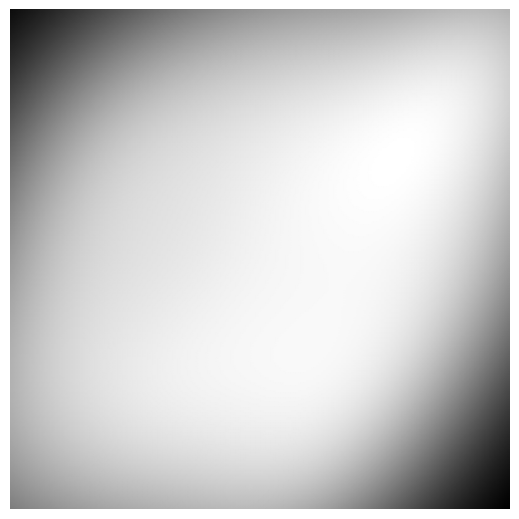

In [ ]:
#| hide

if __name__ == "__main__" and in_ipython():
    test_butterfly()


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()